In [1]:
import locale

locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
import math
import numpy as np
from shapely.geometry import Point, LineString, Polygon, box, MultiPolygon
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import osmnx as ox
import re
import os
import requests
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import warnings
from scipy.spatial.distance import cdist
import itertools

import cv2
import torch
from torchvision.ops import box_convert
import torchvision.ops as ops

import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

warnings.filterwarnings("ignore")

GOOGLE_MAPS_API_KEY = ...
PARCEL_URL = "https://data.cityofberkeley.info/api/geospatial/bhxd-e6up?method=export&format=GeoJSON"

In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Loading GeoDataframe and Google Street View Images

In [4]:
from geo_utils import get_area_bbox, generate_network_pts, load_gsv_img_from_coords

# Define the area of interest
area = 'Hilgard Ave, Berkeley, CA'

# Retrieve the bounding box for the specified area
bbox = get_area_bbox(area, key=GOOGLE_MAPS_API_KEY)

# Generate sample points along the road network within the bounding box
sample_points = generate_network_pts(bbox, samp_dist=0.00015)

# Download Google Street View images using the generated sample points
load_gsv_img_from_coords(sample_points, save_dir='gsv_images')

100%|███████████████████████████████████████████| 453/453 [00:38<00:00, 11.76it/s]


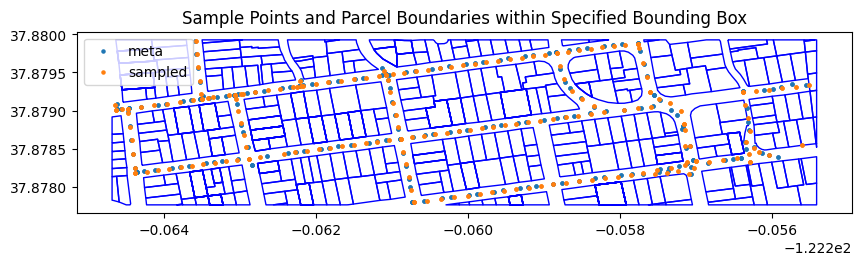

In [5]:
from geo_utils import load_parcels, clip_gdf_to_bbox

parcels = load_parcels()
bounded_gdf = clip_gdf_to_bbox(parcels, bbox)

fig, ax = plt.subplots(figsize=(10, 10))
bounded_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1)
sample_points.set_geometry('meta_pt').plot(ax=ax, markersize=5, label='meta')
sample_points.set_geometry('points').plot(ax=ax, markersize=5, label='sampled')
plt.legend()
plt.title("Sample Points and Parcel Boundaries within Specified Bounding Box")
plt.show()

##### Object Detection on Series of Images

In [11]:
from object_detection_utils import load_images, depth_estimate, convert_depth_to_coords, object_grounded_segmentation, generate_3d_bounding_boxes, reformat_detections

images = load_images(folder_path='./gsv_images')[:10]

# Estimate depth maps for the images
depth_maps = depth_estimate(images)

# Project pixels onto a 3D plane
coords = convert_depth_to_coords(depth_maps)

# Perform object detection
detections = object_grounded_segmentation(images, ['vegetation', 'house', 'fire hydrant'])

# Reformat detections into a dictionary grouped by label
detection_dict = reformat_detections(detections)

# Estimate 3D bounding boxes for specific objects
detection_dict['vegetation']['coords'] = generate_3d_bounding_boxes(detection_dict['vegetation']['mask'], coords, 'vegetation')
detection_dict['house']['coords'] = generate_3d_bounding_boxes(detection_dict['house']['mask'], coords, 'house')

Using cache found in /home/eecs/qijun.li/.cache/torch/hub/isl-org_ZoeDepth_main


Overwriting config with config_version kitti
img_size [384, 768]


Using cache found in /home/eecs/qijun.li/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  768
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_K.pt
Loaded successfully


##### Geospatial Relationships between Objects

In [108]:
from object_detection_utils import dist, group_distances

# Calculate distances between vegetation and house coordinates.
distances = dist(detection_dict['vegetation']['coords'], detection_dict['house']['coords'], 'veg', 'house')

# Group the distances to vegetation by applying a minimum threshold and filter.
dist_house_to_veg_min = group_distances(distances, detection_dict['vegetation'], detection_dict['house'], fn=min, thres=0.5)
dist_house_to_veg_min.head(5)

,image_index,coords_veg,coords_house,distance,box_veg,box_house
0,0,"((-1.6763145849108692, -0.6509839221835136, 1....","((-2.784065298736095, -0.854041305184364, 2.00...",0.713033,"[246, 0, 551, 447]","[427, 254, 639, 425]"
1,0,"((-1.6332854956388472, -0.5762466851621868, 1....","((-2.784065298736095, -0.854041305184364, 2.00...",0.301067,"[295, 262, 551, 443]","[427, 254, 639, 425]"
2,0,"((0.38251179456710815, -0.4182278707623479, 2....","((-2.784065298736095, -0.854041305184364, 2.00...",0.874376,"[159, 268, 270, 368]","[427, 254, 639, 425]"
3,0,"((1.8507653295993798, 0.40312765240669224, 3.2...","((-2.784065298736095, -0.854041305184364, 2.00...",0.580896,"[57, 203, 137, 284]","[427, 254, 639, 425]"
4,1,"((-1.6970360189676277, -0.4076035536825655, 2....","((-1.9194598078727716, 0.9010739028453827, 2.1...",0.150705,"[417, 186, 639, 376]","[417, 133, 639, 237]"


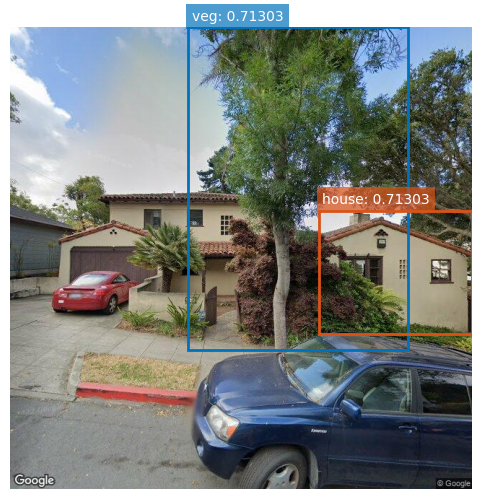

In [109]:
from plot_utils import *

# Plot the distance between first vegetation and house pair for the first image
plot_dist(images[0], dist_house_to_veg_min.iloc[0])

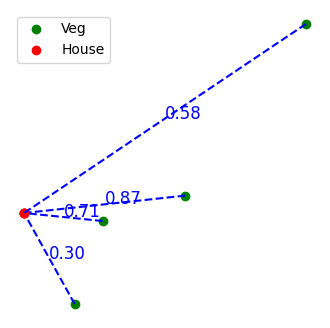

In [110]:
from plot_utils import estimate_locations

# Estimate the locations and plot the distance between vegetation and house for the image with index 0.
estimate_locations(dist_house_to_veg_min, 0)

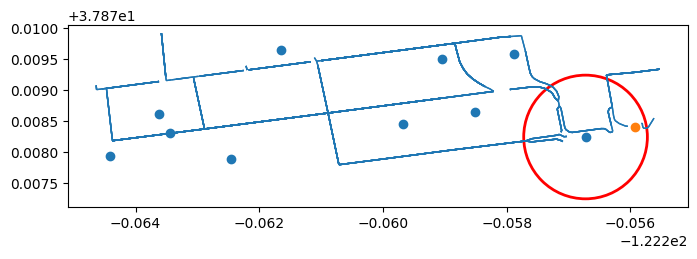

In [111]:
from object_detection_utils import nearest_object_existence

def sample_points_from_bbox(bbox, n, crs="EPSG:4326"):
    """
    Sample n points uniformly from a bounding box.

    Parameters:
    bbox (tuple): A tuple of (minx, miny, maxx, maxy) defining the bounding box.
    n (int): The number of points to sample.
    crs (str): Coordinate reference system of the points.

    Returns:
    GeoDataFrame: A GeoDataFrame containing the sampled points.
    """
    np.random.seed(43)
    minx, miny, maxx, maxy = bbox.bounds

    xs = np.random.uniform(minx, maxx, n)
    ys = np.random.uniform(miny, maxy, n)
    
    points = [Point(x, y) for x, y in zip(xs, ys)]
    
    points_gdf = gpd.GeoDataFrame(geometry=points, crs=crs)
    
    return points_gdf

sample_hydrants = sample_points_from_bbox(bbox, 10)
nearest_exist = nearest_exist = nearest_object_existence(sample_hydrants, detection_dict['fire hydrant'], meta=sample_points, max_dist=0.001, visualize=True)

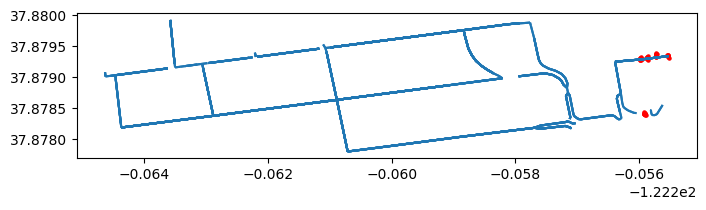

In [112]:
from object_detection_utils import estimate_object_locations

# Estimate geographic locations for the detected objects
geoloc_results = estimate_object_locations(detection_dict['vegetation']['coords'], meta=sample_points, visualize=True)